In [1]:
from   IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [8]:
from scipy.integrate import solve_ivp
import numpy as np, pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import torch
import gpytorch
import math

In [9]:
from GPutils import add_fwd_cols, updatePLT, ExactGPModel, solveLotkaVolterra

# Fit a 2-dimensional GP to imbalance data of INTC

In [4]:
asset_name         = 'INTC'
predictive_feature = 'imbalance_1'
tick_size          = 0.01

# predictive horizon 
fwd_cols  = []
#fwd_col_ls = (1, 5, 10, 20, 50, 40, 60, 100, 300, 500, 1000)
fwd_col_ls = [int(s) for s in np.linspace(10, 1000, 31)] 
for w in fwd_col_ls:
    fwd_cols += [f'fwd_price_move_{w}']

In [ ]:
i = 0
for filename in os.listdir(os.path.join(data_path, asset_name)):
    i += 1
    f = os.path.join(os.path.join(data_path, asset_name), filename)
    if 'orderbook' in f:
        if os.path.isfile(f):
            trade_date = f.split('_')[2]
            print('*****************************************')
            print('*     ', asset_name)
            print('*****************************************')
            print('%: ', 100*(round(i/len(os.listdir(os.path.join(data_path, asset_name))), 2)) , "%")
            print('File name: ', filename)
            if not os.path.isfile(f'{str(feature_path)}/{asset_name}_{trade_date}_LOB_features.pkl'):
                try:
                    LOB_data, LOB_messages      = get_LOB_data(data_path, asset_name, trade_date)
                    print('got the data')
                    LOB_features, LOB_messages  = get_LOB_features(LOB_data, LOB_messages, trade_date, tick_size)
                    LOB_features.to_pickle(f'{str(feature_path)}/{asset_name}_{trade_date}_LOB_features.pkl')
                    LOB_features = LOB_features.set_index('timestamp')
                except Exception as e:
                    print('Error: ', str(e))
            clear_output(wait=True)

In [5]:
cutoff_count   = 10
filenames      = os.listdir('../data')
trade_dates    = np.sort([fn.split('_')[1] for fn in filenames if asset_name in fn])
dic_results    = {}

print('Building the predictive surface from dates:', trade_dates[:3])

for trade_date in trade_dates[:3]:
    #print('Reading:',trade_date)
    features_fn   = f'{asset_name}_{trade_date}_LOB_features.pkl'
    try:
        LOB_features = pd.read_pickle(f'../data/{features_fn}')
        
        LOB_features[predictive_feature] = LOB_features[predictive_feature].round(1)
        add_fwd_cols(fwd_cols, LOB_features)
        LOB_features_predictive = LOB_features[[predictive_feature] + fwd_cols].dropna()
        
        counts = (LOB_features_predictive[[predictive_feature] + fwd_cols].groupby(predictive_feature).count())
        avgs   = (LOB_features_predictive[[predictive_feature] + fwd_cols].groupby(predictive_feature).mean())
        avgs[counts<cutoff_count]=np.nan
        avgs = avgs.sort_index()

        dic_results[trade_date] = (counts, avgs)

    except Exception as e:
        print('Could not load asset ', asset_name, 'for date', trade_date)
        print(str(e))

Building the predictive surface from dates: ['2023-03-01' '2023-03-02' '2023-03-03']


In [6]:
avg_results  = {}
_results     = {}
smooth_w     = 1

# Cleaning of results
avg_results[asset_name] = {}
tmp_dico = {}
for s in dic_results.keys():
    counts, avgs = dic_results[s]
    avgs = avgs/tick_size # avgs / asset_stats[asset_name]['avg_baspread'] / tick_size
    tmp_dico[s] = avgs.sort_index()
    
for fwd_col in fwd_cols:
    avg_results[fwd_col] = pd.concat((tmp_dico[s][fwd_col] for s in tmp_dico.keys()), axis=1).sort_index().mean(axis=1)
    avg_results[fwd_col] = avg_results[fwd_col][::-1].rolling(smooth_w).mean()[::-1].rolling(smooth_w).mean()

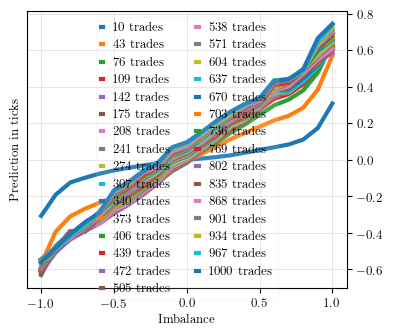

In [7]:
updatePLT(W=4, l=7, w=6, fontsize=9)

plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = True 
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = False

fig, ax = plt.subplots(1, 1, sharey=True, sharex=True)

for i in range(len(fwd_cols)):
    avgs    = avg_results[fwd_cols[i]]
    ax.plot(avgs.dropna(), lw=3)

ax.grid(axis='both', color='gainsboro', linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)
ax.yaxis.set_label_position("left")

ax.legend([f'{s} trades'  for s in fwd_col_ls], loc='upper center', fancybox=True, framealpha=0.1, handlelength=0.2, ncol=2)

ax.set_ylabel('Prediction in ticks')
ax.set_xlabel('Imbalance')

plt.tight_layout()
plt.savefig(f'results/Predictive_Power_Imbalance.pdf', bbox_inches='tight')

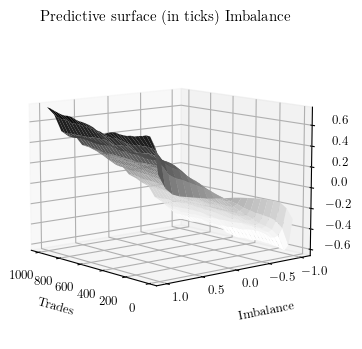

In [8]:
updatePLT(W=4, l=4, w=6, fontsize=9)

pred_surface         = pd.concat((avg_results[fwd_col] for fwd_col in fwd_cols), axis=1).sort_index()
pred_surface.columns = fwd_col_ls

Ts_, Is_ = np.meshgrid(fwd_col_ls, list(pred_surface.index), indexing='ij')

fig      = plt.figure()
ax       = fig.add_subplot(projection = '3d')

ax.view_init(elev=10, azim=140)
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = True 
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = False

surf = ax.plot_surface(Ts_, Is_, pred_surface.T.values, 
                        cstride=1, rstride = 1, cmap='Greys', linewidth=0, antialiased=True) 

ax.grid(axis = 'both', color = 'gainsboro', linestyle = '-', linewidth = 0.5)
#ax.set_axisbelow(True)
#ax.yaxis.set_label_position("left")

ax.set_title('Predictive surface (in ticks) Imbalance')
ax.set_xlabel('Trades')
ax.set_ylabel('Imbalance')
ax.set_zlabel('Prediction in ticks')

plt.savefig(f'results/Predictive_surface_Imbalance.pdf', bbox_inches='tight')
plt.show()

In [9]:
##############################
# fit the 2-dimensional GP
##############################

# get observations
observations = pred_surface.unstack(0).reset_index()
observations.columns = ['trades', 'imbalance', 'prediction']

# construct training data
nb_max_trades= observations.trades.max()
train_x      = torch.tensor(observations.trades)/nb_max_trades
train_a      = torch.tensor(observations.imbalance)
full_train_x = torch.cat((train_x.contiguous().view(train_x.numel(), 1),
                          train_a.contiguous().view(train_a.numel(), 1)),
                          dim=1)

train_y      = torch.tensor(observations.prediction)

# select n random obs points
if False:
    random_obs_indices = torch.randint(len(full_train_x), (100,))
    full_train_x       = full_train_x[random_obs_indices]
    train_y            = train_y[random_obs_indices]

# Here we have two iterms that we're passing in as train_inputs
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model      = ExactGPModel(full_train_x.float(), 
                          train_y.float(), likelihood, 200)

# Find optimal model hyperparameters
model.trainn()

# Set into eval mode
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

/Users/faycaldrissi/miniconda/envs/aoe/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/var/folders/h3/cyxpytps41d3jmsv99t0x7ww0000gn/T/ipykernel_11553/1921984206.py:59: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


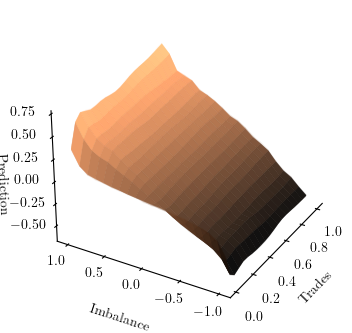

In [10]:
##############################
# Plot the 2-dimensional GP
##############################
updatePLT(W=6, l=6, w=4)

# Generate predictions
n_test  = 20
spacex, spacea   = torch.linspace(observations.trades.min()/nb_max_trades, 
                                  observations.trades.max()/nb_max_trades, n_test),\
                   torch.linspace(observations.imbalance.min(), observations.imbalance.max(), n_test)
spacex_, spacea_ = torch.meshgrid(spacex, spacea, indexing='ij')
test_ax          = torch.stack([spacex_.reshape(n_test * n_test, 1), 
                                spacea_.reshape(n_test * n_test, 1)], -1).squeeze(1)

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred_y = model(test_ax)
    
    # Get lower and upper confidence bounds
    lower, upper    = observed_pred_y.confidence_region()
    
# Initialize plots
fig = plt.figure(constrained_layout=True)

ax  = fig.add_subplot(1, 1, 1, projection='3d')

ax.view_init(elev=30, azim=210)
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0)); ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0)); ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.set_zlabel(r'Prediction', rotation=90)
ax.set_xlabel('Trades')
ax.set_ylabel('Imbalance')
ax.zaxis.labelpad = -0.1

surf   = ax.plot_surface(spacex_, spacea_, observed_pred_y.mean.reshape(n_test, n_test), 
                            cmap="copper", linewidth=0.2, alpha=0.8, label='mean')


if False:
    surf   = ax.plot_surface(spacex_, spacea_, lower.reshape(n_test, n_test), 
                                cmap="gray", linewidth=0.4, alpha=0.4, label='lower')
    surf   = ax.plot_surface(spacex_, spacea_, upper.reshape(n_test, n_test), 
                                cmap="copper", linewidth=0.4, alpha=0.4, label='upper')


if False:
    for (i_x, _xa) in enumerate(full_train_x):
        if i_x == 0:
            ax.scatter(_xa[0], _xa[1], train_y[i_x], c='red', marker='o', label='observation data', alpha=1)
        else:
            ax.scatter(_xa[0], _xa[1], train_y[i_x], c='red', marker='o', alpha=1)

if False:
    for i in range(10):
        surf   = ax.plot_surface(spacex_, spacea_, observed_pred_y.sample().reshape(n_test, n_test).double(), 
                                cmap="copper", linewidth=0.4, alpha=0.1)

#plt.savefig('results/GP5.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

# Simulation: trade INTC for a TWAP schedule of 1000 events

In [11]:
trade_date    = trade_dates[3]
features_fn   = f'{asset_name}_{trade_date}_LOB_features.pkl'

try:
    LOB_features = pd.read_pickle(f'../data/{features_fn}')
except Exception as e:
    print('Failed to locate file:', f'../data/{features_fn}')

Sim_data = LOB_features.iloc[1000:2000, :]
Sim_data.tail()

,mid_price,ask_1,bid_1,imbalance_1,ba_spread,timestamp,macd_1200_2600_900,macd_120_260_90,macd_12_26_9,macd_8_24_9,bid_volume_1,ask_volume_1,message,micro,time_of_day
time,,,,,,,,,,,,,,,
34261.680357,26.525,265300,265200,-0.423423,0.01,2023-03-06 09:31:01.680357,0.0,8.685458,-1.223801,-1.566971,608,1501,BC,-0.150841,0.0
34261.724434,26.525,265300,265200,-0.136977,0.01,2023-03-06 09:31:01.724434,0.0,8.654428,-1.199483,-1.494954,608,801,SC,-0.048797,0.0
34261.725580,26.525,265300,265200,0.334994,0.01,2023-03-06 09:31:01.725580,0.0,8.617915,-1.168083,-1.419596,1608,801,BL,0.119339,0.0
34261.783952,26.525,265300,265200,0.455862,0.01,2023-03-06 09:31:01.783952,0.0,8.576166,-1.131582,-1.342635,1608,601,SC,0.162397,0.0
34261.784023,26.525,265300,265200,0.600796,0.01,2023-03-06 09:31:01.784023,0.0,8.529425,-1.091076,-1.265456,1608,401,SC,0.214029,0.0


# Strategy simulation

In [12]:
###############
# Parameters 
##############

# performance criterion
phi  = 0.05
beta = 5
c    = 1e-5 # transient impact
k    = 1e-3 # trading friction

# Time steps
T    = 1 # here it means a 1000 trades
nb_t = 1000 # in 1001 steps
dt   = T / (nb_t - 1)

# Fundamental price
F0            = Sim_data.iloc[0].mid_price 

# transient impact
sigma_transient = 0.1

# Inventory to liquidate
Q0       = 100 # shares of INTC

##############################
# Target strategy: TWAP 
############################
q_target = np.linspace(Q0, 0, nb_t)

In [13]:
###############
# Solve g2, g3, g4 
##############
Gt, ts = solveLotkaVolterra(_phi  = phi, _beta = beta, _c = c, _T = T, _nb_t = nb_t, _k = k)
g3 = Gt[1, ::-1]; g4 = Gt[2, ::-1]; g2 = g4 / beta  - Gt[0, ::-1]

### Get fundamental prices & signals

Text(0, 0.5, 'INTC (\\$)')

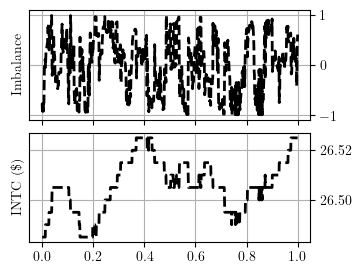

In [14]:
# random parameters
np.random.seed(13)

# Simulate a signal:  OU process
imbalance   = Sim_data.imbalance_1.values
F           = Sim_data.mid_price.values

updatePLT(3.5, l=4, w=3, fontsize=10)
fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True, sharex=True)
ax1.plot(ts, imbalance, color='k', lw=2, ls='--')
ax2.plot(ts, F,         color='k', lw=2, ls='--')
ax1.grid(); ax2.grid()
ax1.set_ylabel('Imbalance'); ax2.set_ylabel('INTC (\$)')

### Get optimal tracking speed

In [15]:
########################################################
# one example: generate predictions between t and T.
########################################################
if False:
    it     = 0
    n_test = nb_t - it # number of points to integrate
    imb    = imbalance[it] # imbalance that the trade observes

    spacex, spacea   = torch.linspace(ts[0], ts[-1]-ts[it], n_test), torch.linspace(imb, imb, 1)

    spacex_, spacea_ = torch.meshgrid(spacex, spacea, indexing='ij')
    test_ax          = torch.stack([spacex_.reshape(n_test, 1), 
                                    spacea_.reshape(n_test, 1)], -1).squeeze(1)

    # Make predictions
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred_y = model(test_ax)
    mc_alpha = observed_pred_y.sample().reshape(n_test, 1).double()
    
    plt.plot(mc_alpha)

In [16]:
####################
# compute g1 with mc
####################
g1_mc  = np.zeros(nb_t)
N      = 10 # need more, but computations are slow
for n in range(N):
    if (n%5==0): print(n)
    one_g1 = np.zeros(nb_t)
    
    # at each time t, observe the imbalance, and generate
    for it in range(nb_t):
        # generate the expected alpha at each time s in [t, T]
        imb    = imbalance[it] # imbalance that the trade observes
        n_test = nb_t-it   # number of points to integrate
        
        # generate a path of predictions from t to T
        spacex, spacea   = torch.linspace(ts[0], ts[-1]-ts[it], n_test), torch.linspace(imb, imb, 1)
        spacex_, spacea_ = torch.meshgrid(spacex, spacea, indexing='ij')
        test_ax          = torch.stack([spacex_.reshape(n_test, 1), 
                                        spacea_.reshape(n_test, 1)], -1).squeeze(1)
        
        # Make predictions
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred_y = model(test_ax)
            mc_alpha        = observed_pred_y.sample().reshape(n_test, 1).double()
        
        # compute the integral
        one_g1[it] = sum(((mc_alpha[iss-it,0] + phi * q_target[iss]) * np.exp(np.sum(g2[it:iss] * dt + c*g3[it:iss]*dt)/2/k) * dt 
                            for iss in range(it, nb_t-1)))
        
    g1_mc += one_g1

g1_mc/=N
#np.shape(mc_alpha[:,0] + phi * q_target )

0


/Users/faycaldrissi/miniconda/envs/aoe/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/faycaldrissi/miniconda/envs/aoe/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


5


Text(0.5, 1.0, '$S=I+F$')

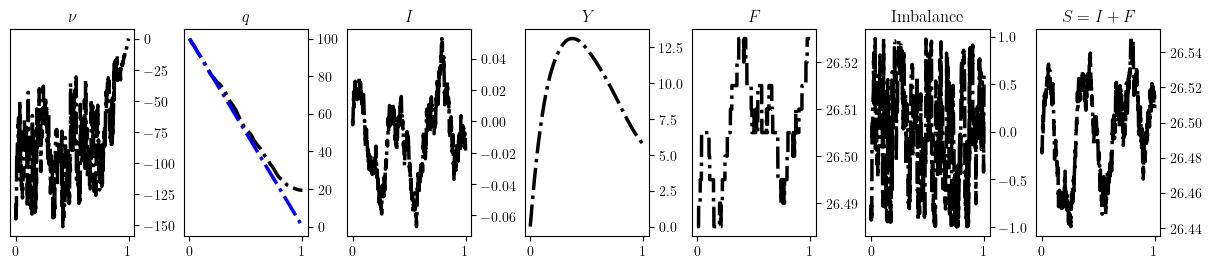

In [17]:
Q        = np.empty((nb_t, 1))
I        = np.empty((nb_t, 1))
Y        = np.empty((nb_t, 1))
nu       = np.empty((nb_t, 1))

Q[0]     = Q0
I[0]     = 0
Y[0]     = 0
nu[0]    = 0

np.random.seed(13)
M2 = np.random.randn(nb_t, 1) * sigma_transient * np.sqrt(dt)

# FBSDE system
for i in range(0, nb_t-1):
    nu[i]   = (g1_mc[i] + g2[i] * Q[i] + g3[i] * I[i] + g4[i] * Y[i]) / 2 / k
    Q[i+1]  = Q[i] + nu[i] * dt    
    Y[i+1]  = Y[i] + (Q[i] - beta * Y[i]) * dt
    I[i+1]  = I[i] + c * nu[i] * dt - beta * I[i] * dt + M2[i]

# plot the solution
updatePLT(W=12, l=14, w=3, fontsize=10)
fig, axes = plt.subplots(1, 7, constrained_layout=True)
axes[0].plot(ts, nu,        color='k', lw=2.5, ls='-.');  axes[0].set_title(r'$\nu$')
axes[1].plot(ts, Q,         color='k', lw=2.5, ls='-.');  axes[1].set_title(r'$Q$')
axes[1].plot(ts, q_target,  color='b', lw=2.5, ls='-.');  axes[1].set_title(r'$q$')
axes[2].plot(ts, I,         color='k', lw=2.5, ls='-.');  axes[2].set_title(r'$I$')
axes[3].plot(ts, Y,         color='k', lw=2.5, ls='-.');  axes[3].set_title(r'$Y$')
axes[4].plot(ts, F,         color='k', lw=2.5, ls='-.');  axes[4].set_title(r'$F$')
axes[5].plot(ts, imbalance, color='k', lw=2.5, ls='-.');  axes[5].set_title(r'Imbalance')
axes[6].plot(ts, I[:,0]+F,  color='k', lw=2.5, ls='-.');  axes[6].set_title(r'$S=I+F$') 

Text(0, 0.5, 'Imbalance')

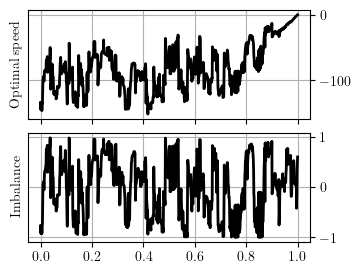

In [23]:
# random parameters
np.random.seed(13)

updatePLT(3.5, l=4, w=3, fontsize=10)
fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True, sharex=True)
ax1.plot(ts, nu, color='k', lw=2, ls='-')
ax2.plot(ts, imbalance,         color='k', lw=2, ls='-')
ax1.grid(); ax2.grid()
ax1.set_ylabel('Optimal speed'); ax2.set_ylabel('Imbalance')

Text(0.5, 1.0, '$g4 * Y / 2k$')

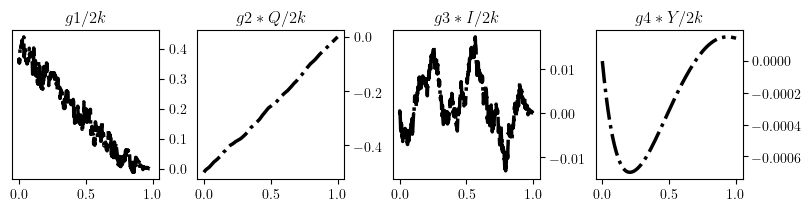

In [24]:
updatePLT(W=8, l=12, w=3, fontsize=10)
fig, axes = plt.subplots(1, 4, constrained_layout=True)
axes[0].plot(ts, dt*g1_mc/2/k,  color='k', lw=2.5, ls='-.'); axes[0].set_title(r'$g1 / 2k$')
axes[1].plot(ts, dt*g2*Q[:,0]/2/k,  color='k', lw=2.5, ls='-.'); axes[1].set_title(r'$g2 * Q / 2k$')
axes[2].plot(ts, dt*g3*I[:,0]/2/k,  color='k', lw=2.5, ls='-.'); axes[2].set_title(r'$g3 * I / 2k$')
axes[3].plot(ts, dt*g4*Y[:,0]/2/k,  color='k', lw=2.5, ls='-.'); axes[3].set_title(r'$g4 * Y / 2k$')
#axes[4].plot(ts, alpha,  color='k', lw=2.5, ls='-.'); axes[4].set_title(r'$\alpha$')